In [8]:
import pandas as pd # 데이터프레임 형태를 다룰 수 있는 라이브러리
import numpy as np
from sklearn.model_selection import train_test_split # 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.

# ANN
import torch
from torch import nn, optim # torch 내의 세부적인 기능을 불러온다. (신경망 기술, 손실함수, 최적화 방법 등)
from torch.utils.data import DataLoader, Dataset # 데이터를 모델에 사용할 수 있도록 정리해 주는 라이브러리
import torch.nn.functional as F # torch 내의 세부적인 기능을 불러온다. (신경망 기술 등)

# Loss
from sklearn.metrics import mean_squared_error # Regression 문제의 평가를 위해 MSE(Mean Squared Error)를 불러온다.

# Plot
import matplotlib.pyplot as plt # 시각화 도구

# datasets
from sklearn.datasets import load_boston


In [9]:
datasets = load_boston()
x = datasets.data
y = datasets.target

C:\ProgramData\Anaconda3\envs\realtorch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California ho

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x,y, train_size= 0.2, random_state=42)

In [16]:
print(x_train.shape, x_test)

(101, 13) [[9.1780e-02 0.0000e+00 4.0500e+00 ... 1.6600e+01 3.9550e+02 9.0400e+00]
 [5.6440e-02 4.0000e+01 6.4100e+00 ... 1.7600e+01 3.9690e+02 3.5300e+00]
 [1.0574e-01 0.0000e+00 2.7740e+01 ... 2.0100e+01 3.9011e+02 1.8070e+01]
 ...
 [5.2058e-01 0.0000e+00 6.2000e+00 ... 1.7400e+01 3.8845e+02 9.5400e+00]
 [2.5199e-01 0.0000e+00 1.0590e+01 ... 1.8600e+01 3.8943e+02 1.8060e+01]
 [2.1719e-01 0.0000e+00 1.0590e+01 ... 1.8600e+01 3.9094e+02 1.6030e+01]]


In [14]:
class TensorData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.len

trainsets = TensorData(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle= True)
testsets = TensorData(x_test, y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size = 32, shuffle = False)

In [29]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13,64, bias = True)   # 피쳐 개수가 13개여서 입력층의 노드가 13개
        self.fc2 = nn.Linear(64, 32, bias = True)
        self.fc3 = nn.Linear(32, 1, bias = True)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        return(x)
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.


In [30]:
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.001, weight_decay= 1e-7)  
#  weight_decay는 L2 정규화에서 penalty 값을 의미한다.  > 값이 클수록 제약조건이 강함


In [31]:
loss_ = []
n = len(trainloader)
for epoch in range(400):
    running_loss = 0.0
    for data in trainloader:
        inputs, values = data  # data에는 x, y가 들어 있음
        optimizer.zero_grad()  
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    loss_.append(running_loss/n)

C:\ProgramData\Anaconda3\envs\realtorch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\ProgramData\Anaconda3\envs\realtorch\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


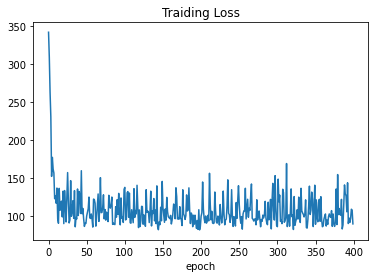

In [32]:
plt.plot(loss_)
plt.title('Traiding Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
def evaluation(dataloader):
    
    predictions = torch.tensor([], dtype = torch.float)
    actual = 